# Plot figure 3

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

In [2]:
colors = {'normal': '#69bade', 'q': '#f3c33b', 'bad': '#f34d4d'}

In [3]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
def getBad(filename, Aq=1, Bq=2, As=2, Bs=3):
    jpub_count = pd.read_csv(filename, sep='\t',
                    usecols=['EditorId','IssnId','BeAvg','AfAvg','left','right','Year0'],
                    dtype={'EditorId':int,'IssnId':int,'BeAvg':float,'AfAvg':float,
                           'left':int,'right':int,'Year0':int})
    
    normal = jpub_count[jpub_count.apply(lambda row: row.AfAvg < max(row.BeAvg * Bq, Aq), axis=1)]
    Q = jpub_count[jpub_count.apply(lambda row: row.AfAvg >= max(row.BeAvg * Bq, Aq), axis=1)]
    S = jpub_count[jpub_count.apply(lambda row: row.AfAvg >= max(row.BeAvg * Bs, As), axis=1)]
    
    print(f'# Aq: {Aq}, Bq {Bq}, As: {As}, Bs: {Bs} | ',
          f'questionable: {round(Q.shape[0]/jpub_count.shape[0]*100, 2)}%,\
          suspicious: {round(S.shape[0]/jpub_count.shape[0]*100, 2)}%')
    
    return normal, Q, S

In [5]:
pubCountFile = '../data/figure_3/EditorJournalPub_5.csv'

n, q, s = getBad(pubCountFile)

n = n[['EditorId','IssnId','left','right','Year0']].drop_duplicates()
s = s[['EditorId','IssnId','left','right','Year0']].drop_duplicates()
q = q[['EditorId','IssnId','left','right','Year0']].drop_duplicates()

# Aq: 1, Bq 2, As: 2, Bs: 3 |  questionable: 8.27%,          suspicious: 1.81%


In [6]:
jpub_count = pd.read_csv(pubCountFile, sep='\t',
                         usecols=['EditorId','IssnId','BeAvg','AfAvg'],
                         dtype={'EditorId':int,'IssnId':int,'BeAvg':float,'AfAvg':float}).fillna(0)
print(jpub_count.shape)

(12995, 4)


## a

In [22]:
print(jpub_count.shape)

to_plot= jpub_count.assign(Before_log = jpub_count.BeAvg.apply(np.log10))
to_plot= to_plot.assign(After_log = to_plot.AfAvg.apply(np.log10))
to_plot = to_plot.assign(Before_log = to_plot.Before_log.apply(lambda x: -0.8 if x == -np.inf else x))
to_plot = to_plot.assign(After_log = to_plot.After_log.apply(lambda x: -0.9 if x == -np.inf else x))

scatter_normal = n.merge(to_plot, on=['EditorId','IssnId'])
scatter_q = q.merge(to_plot, on=['EditorId','IssnId'])
scatter_bad = s.merge(to_plot, on=['EditorId','IssnId'])

print(scatter_normal.shape, scatter_q.shape, scatter_bad.shape)

(12995, 4)
(11920, 9) (1075, 9) (235, 9)


[-0.8, -0.6989700043360187, -0.3010299956639812, 0.0, 0.3010299956639812, 0.6989700043360189, 1.0]
CPU times: user 415 ms, sys: 0 ns, total: 415 ms
Wall time: 417 ms


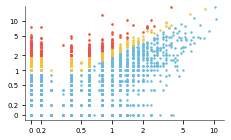

In [24]:
%%time
cm = 1/2.54  # centimeters in inches

ax = plt.gca()

ax.scatter(x=scatter_normal.Before_log, y=scatter_normal.After_log, c=colors['normal'],
           label = 'Normal editors', s=2)
ax.scatter(x=scatter_q.Before_log, y=scatter_q.After_log, c=colors['q'],
           label = 'Questionable editors', s=2)
ax.scatter(x=scatter_bad.Before_log, y=scatter_bad.After_log, c=colors['bad'],
           label = 'Suspicious editors', s=2)
#ax.set_xlabel("Mean number of papers per year in the editor’s journal\nbefore joining as editor") #$\bf{before}$
#ax.set_ylabel("Mean number of papers per year in the\neditor’s journal after joining as editor") # $\bf{after}$

xlabels = ['0']
xlabels.extend([0.2, 0.5, 1, 2, 5, 10])
xticks = [-0.8]
xticks.extend(np.log10(x) for x in [0.2, 0.5, 1, 2, 5, 10])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlim(-0.85, 1.1)

print(xticks)

ylabels = ['0']
ylabels.extend([0.2, 0.5, 1, 2, 5, 10])
yticks = [-0.9]
yticks.extend(np.log10(x) for x in [0.2, 0.5, 1, 2, 5, 10])
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylim(-1, 1.29)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# ax.legend(loc='lower right')

set_size(7*cm, 4*cm, ax)
plt.savefig("../figures/main_2_scatter.pdf", bbox_inches = 'tight', pad_inches = 0)

## b

In [79]:
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
import scipy
from scipy import stats
import sys
sys.path.insert(1, '../src')

import utils

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), stats.sem(a), stats.t.ppf((1+conf)/2., len(a)-1)
    return mean, m*sem

In [26]:
def printTtest(a, b):
    s1 = a.shape[0]
    s2 = b.shape[0]
    m1 = a.mean()
    m2 = b.mean()
    
    ttest = ttest_ind(a, b, permutations=1000, random_state=42)
    pval = round(ttest.pvalue, 3) if ttest.pvalue > 0.001 else 'p < 0.001'
    
    std_pooled = np.sqrt( (np.std(a)**2 + np.std(b)**2)/2)
    cohend = abs(a.mean()-b.mean())/std_pooled
    
    print('Means', round(m1, 2), round(m2, 2))
    print('Shapes', s1, s2)
    
    print(f"$t_{s1+s2-2} = {round(ttest.statistic, 2)}$, $P = {pval}", "Cohen'd:", cohend)
    print('rel', ttest_rel(a, b))

In [27]:
def expand(df):
    # expand five year before and five year after
    # df: n, q, or s (with left and right)
    
    res = []
    for year in range( df.left.min(), df.right.max()+1):
        sub = df[(df.left <= year) & (df.right >= year)].assign(Year = year)
        sub = sub.assign(EditorYear = year-sub.Year0)
        res.append(sub)
    
    return pd.concat(res, ignore_index=True, sort=False)

In [46]:
def plotScatter(df, ax, c, window):
    means = []
    err = []
    
    for year in range(-window+1, 1):
        v = df[df.EditorYear == year].JournalCount.values
        
        me, sem = meanCI(v, 0.95) # CI here; standard error is: sem = scipy.stats.sem(v)
        
        err.append(sem)
        means.append(me)
        
    x = [_ for _ in range(-window+1, 1)]
    popt, pcov = curve_fit(f, x, means)
    ax.errorbar(x, means, yerr=err, color=c, fmt='o', elinewidth=0.5, ms=2)
    
    print([round(x, 2) for x in means])
    
    # x = [_ for _ in range(-10, 11)]
    ax.plot(x, [f(_, *popt) for _ in x], color=c, linewidth=1)
                  
    means = []
    err = []
    
    for year in range(1, window+1):
        v = df[df.EditorYear == year].JournalCount.values
        
        me, sem = meanCI(v, 0.95) # CI here; standard error is: sem = scipy.stats.sem(v)
        
        err.append(sem)
        means.append(me)
        
    x = [_ for _ in range(1, window+1)]
    popt, pcov = curve_fit(f, x, means)
    ax.errorbar(x, means, yerr=err, color=c, fmt='o', elinewidth=0.5, ms=2)
    
    x = [_ for _ in range(1, window+1)]
    ax.plot(x, [f(_, *popt) for _ in x], color=c, linewidth=1)
    
    print([round(x, 2) for x in means])
    
#     print('T-test',
#           ttest_ind(df[df.EditorYear == 0].JournalCount, df[df.EditorYear == 1].JournalCount,
#                     permutations=1000, random_state=42))
    
    #printTtest(df[df.EditorYear == 0].JournalCount, df[df.EditorYear == 1].JournalCount)    

In [47]:
def plotPub(ax, window,
            norm_editor_pub,
            q_editor_pub,
            bad_editor_pub):
    
    plotScatter(norm_editor_pub, ax, colors['normal'], window)
    plotScatter(q_editor_pub, ax, colors['q'], window)
    plotScatter(bad_editor_pub, ax, colors['bad'], window)
    
    #ax.spines['left'].set_position(('data', 0))
    ax.vlines(0.5, 0, 5, color='grey', alpha=0.5, linestyles='dashed', linewidth=1)
    #ax.set_ylabel("Number of papers in the\neditor's journal each year")
    ax.set_ylim(0, 4.25)
    ax.set_yticks([1, 2, 3, 4])

In [60]:
def plotFigure2b(ax, window):
    ax.set_xlim(-window+0.8, window+0.2)
    
    #xticks = [x if x <=0 else x - 1 for x in range(-window+1, window+2, 2)]
    xticks = [x for x in range(-4, 6)]
    ax.set_xticks(xticks)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')
    
    editor_pub = (
        pd.read_csv("../data/figure_3/EditorJournalPublicationNoEditorial_5.csv",sep='\t',
                    usecols=['EditorId','IssnId','Year0','Year','Editorial'],
                    dtype={'EditorId':int,'IssnId':int,'Year0':int,'Year':int,'Editorial':int})
        .reset_index().rename(columns={'index':'PaperId'})
        
        .query('Editorial == 0')
        .assign(EditorYear = lambda df: df.Year - df.Year0)
        .groupby(['EditorId','IssnId','Year0','EditorYear','Year']).PaperId.nunique().reset_index()
        .rename(columns={'PaperId':'JournalCount'})
    )
    print(editor_pub.shape)
    
    beAfAvg_file = f'../data/figure_3/EditorJournalPub_{window}.csv'
    n, q, s = getBad(beAfAvg_file)
    
    bad_editor_pub = editor_pub.merge(expand(s),
                                      on=['EditorId','IssnId','Year','EditorYear','Year0'], how='right').fillna(0)
    q_editor_pub = editor_pub.merge(expand(q),
                                    on=['EditorId','IssnId','Year','EditorYear','Year0'], how='right').fillna(0)
    norm_editor_pub = editor_pub.merge(expand(n),
                                       on=['EditorId','IssnId','Year','EditorYear','Year0'], how='right').fillna(0)
    
    #print(bad_editor_pub.shape, q_editor_pub.shape, norm_editor_pub.shape)
    
    plotPub(ax, window, norm_editor_pub, q_editor_pub, bad_editor_pub)
    
    return [norm_editor_pub, q_editor_pub, bad_editor_pub]

(24470, 6)
# Aq: 1, Bq 2, As: 2, Bs: 3 |  questionable: 8.27%,          suspicious: 1.81%
[0.22, 0.24, 0.27, 0.28, 0.31]
[0.29, 0.27, 0.27, 0.27, 0.27]
[0.28, 0.3, 0.38, 0.44, 0.54]
[1.73, 1.81, 1.96, 1.97, 1.92]
[0.27, 0.33, 0.44, 0.55, 0.69]
[2.72, 3.14, 3.64, 3.64, 3.31]


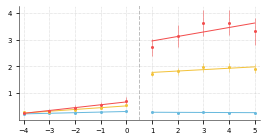

In [61]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(10*cm, 5*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()
df = plotFigure2b(ax, 5)

set_size(8.5*cm, 4*cm, ax)
#plt.savefig(f"../figures/main_2_paper_trend.pdf",bbox_inches = 'tight', pad_inches = 0)
# [0.22, 0.24, 0.27, 0.28, 0.31]
# [0.29, 0.27, 0.27, 0.27, 0.27]
# [0.28, 0.3, 0.38, 0.44, 0.54]
# [1.73, 1.81, 1.96, 1.97, 1.92]
# [0.27, 0.33, 0.44, 0.55, 0.69]
# [2.72, 3.14, 3.64, 3.64, 3.31]

In [78]:
utils.bootstrapTTest(df[0], 'JournalCount', 'EditorYear', 0, 1)
utils.bootstrapTTest(df[1], 'JournalCount', 'EditorYear', 0, 1)
utils.bootstrapTTest(df[2], 'JournalCount', 'EditorYear', 0, 1)

$t_{23838}$ = -2.32, $P$ = 0.011, $\beta$ = -0.03, 95\% CI = -0.06 -- -0.01
$t_{2148}$ = 18.24, $P < 0.001$, $\beta$ = 0.69, 95\% CI = 0.62 -- 0.77
$t_{468}$ = 11.47, $P < 0.001$, $\beta$ = 0.83, 95\% CI = 0.69 -- 0.97


## c

In [13]:
def plotBars(G, axes=None, ylim=10):
    
    if axes is None:
        ax = plt.subplot(1,3,1)
    else:
        ax = axes[0]
    plotDiff(G['n_count'], ax, 'green')
    ax.set_ylim(-ylim*0.1, ylim)
    
    if axes is None:
        ax = plt.subplot(1,3,2)
    else:
        ax = axes[1]
    plotDiff(G['q_count'], ax, 'orange')
    ax.set_ylim(-ylim*0.1, ylim)
    
    if axes is None:
        ax = plt.subplot(1,3,3)
    else:
        ax = axes[2]
    plotDiff(G['s_count'], ax, 'red')
    ax.set_ylim(-ylim*0.1, ylim)


    plt.tight_layout()

In [14]:
def ci_diff(sample1, sample2, ci=0.95):

    n1, n2 = sample1.size, sample2.size
    assert(n1==n2)
    s1, s2 = np.std(sample1), np.std(sample2)

    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
    se = sp*np.sqrt(1/n1 + 1/n2)

    degrees_freedom = n1+n2-2
    sample_mean = np.mean(sample1)-np.mean(sample2)
    confidence_interval = scipy.stats.t.interval(ci, degrees_freedom, sample_mean, se)
    
    try:
        assert(round((confidence_interval[0]+confidence_interval[1])/2, 4) == round(sample_mean, 4))
    except Exception as e:
        print(confidence_interval, sample_mean)

    return [abs(x-sample_mean) for x in confidence_interval]

In [15]:
def getStars(pvalue):
    if pvalue >= 0.05:
        stars = ''
    elif pvalue < 0.05 and pvalue >= 0.01:
        stars = '*'
    elif pvalue < 0.01 and pvalue >= 0.001:
        stars = '*\n*'
    elif pvalue < 0.001:
        stars = '*\n*\n*'
    else:
        stars = ''
        # print('pvalue', pvalue)
        
    return stars
    ax.text(row.year+9, mean_diff[ind]+errbar[ind], stars, color='black', ha="center", fontsize=10, linespacing=0.3)

In [24]:
def plotDiff(dfToPlot, ax, c):
    df = dfToPlot.copy()
    df = df.assign(Diff = df.EdiCount - df.AutCount)
    
    df = df[(df.EditorYear >= -4) & (df.EditorYear <= 5)]
    
    ### compute confidence intervals for each year ###
    ci_lo = []
    ci_hi = []
    stars = []
    locs = []
    means = []
    
    for year in range(-4, 6):
        if year == 0: continue
        locs.append(year)
        means.append(df[df.EditorYear == year].Diff.mean())
            
        seed_lo = []
        seed_hi = []
        temp = df[df.EditorYear == year]
        
        if temp.shape[0] == 0:
            lo, hi, star = 0, 0, ''
        else:
            # print(temp.shape)
            pvalue = ttest_ind(temp.EdiCount, temp.AutCount)[1]
            star = getStars(pvalue)
            lo, hi = ci_diff(temp.EdiCount, temp.AutCount)
        
        ci_lo.append(lo)
        ci_hi.append(hi)
        stars.append(star)
        
    ci = [ci_lo, ci_hi]
    ### compute confidence intervals for each year ###
    print(locs)
    ax.bar(locs, means, yerr = ci, color=c, width=0.7,
           ecolor=c, alpha=0.8, linewidth=0.5, edgecolor=c,
            error_kw={'elinewidth':0.5})
    pprintmean(means)
    ### plot stars ###
    for year in range(-4, 6):
        if year == 0: continue
        if year < 0: ind = year + 4
        else: ind = year + 3
        loc = means[ind]+ci_hi[ind] #if means[ind] >= 0 else means[ind]-ci_lo[ind]
        ax.text(year, loc, stars[ind], color=c, ha="center", fontsize=7, linespacing=0.3)
        
    ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], ylim[1]*1.2)
    
    ### plot stars ###
    
    return means, ci_lo, ci_hi

In [17]:
def pprintmean(l):
    for ind, x in enumerate(l):
        print(round(x, 2), end = ' ')
        if ind == 9:
            print('\t', end=' ')
    print()

In [18]:
pubG = {}
pubG['n_count'] = pd.read_csv('../data/figure_3/NormPub.csv',sep='\t')
pubG['q_count'] = pd.read_csv('../data/figure_3/QuesPub.csv',sep='\t')
pubG['s_count'] = pd.read_csv('../data/figure_3/SuspPub.csv',sep='\t')

In [28]:
colors = {'normal': '#69bade', 'q': '#f3c33b', 'bad': '#f34d4d'}

[-4, -3, -2, -1, 1, 2, 3, 4, 5]
0.01 0.02 0.01 -0.02 0.13 0.13 0.14 0.13 0.13 
[-4, -3, -2, -1, 1, 2, 3, 4, 5]
0.0 0.01 -0.02 -0.0 1.49 1.26 1.47 1.32 1.21 
[-4, -3, -2, -1, 1, 2, 3, 4, 5]
0.01 0.03 -0.02 0.07 2.51 2.29 2.72 2.72 2.14 
CPU times: user 454 ms, sys: 24.7 ms, total: 479 ms
Wall time: 482 ms


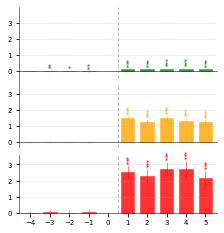

In [29]:
%%time
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(8.5*cm, 8*cm))
plt.rcParams.update({'font.size': 7})

spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, hspace=0)
axes = [fig.add_subplot(spec2[0, 0]), fig.add_subplot(spec2[1, 0]), fig.add_subplot(spec2[2, 0])]

axes[0].set_xticks([])
axes[1].set_xticks([])
# axes[1].set_ylabel("Mean difference between editors and their\nmatched scientists in terms of the number\n"+
#                    "of papers published in the journal")
axes[2].set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_visible(False)
    ax.set_yticks([0, 1, 2, 3])
    ax.grid(b=True, ls=':', axis='y')
    ax.set_xlim(-4.6, 5.6)
    
axes[0].vlines(0.5, -0.4, 4, color='grey', alpha=0.5, linestyles='dashed', linewidth=1)
axes[1].vlines(0.5, -0.4, 3.6, color='grey', alpha=0.5, linestyles='dashed', linewidth=1)
axes[2].vlines(0.5, 0, 3.6, color='grey', alpha=0.5, linestyles='dashed', linewidth=1)


axes[2].spines['left'].set_bounds(0, 3.6)

# axes[2].text(-4, 3.2, "Normal editors", c=colors['normal'], ha='left')
# axes[1].text(-4, 3.2, "Questionable editors", c=colors['q'], ha='left')
# axes[0].text(-4, 3.2, "Suspicious editors", c=colors['bad'], ha='left')


plotBars(pubG, axes, ylim=4)

set_size(7*cm, 7.5*cm, axes[2])
plt.savefig("../figures/main_2_pub_match.pdf",bbox_inches = 'tight', pad_inches = 0)

## d

In [19]:
from scipy.optimize import curve_fit
import scipy
from scipy import stats

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), stats.sem(a), stats.t.ppf((1+conf)/2., len(a)-1)
    return mean, m*sem

In [7]:
def plotScatter(df, ax, c, window, outcome):
    means = []
    err = []
                  
    means = []
    err = []
    
    for year in range(1, window+1):
        v = df[df.EditorYear == year][outcome].values
        
        me, sem = meanCI(v, 0.95) # CI here; standard error is: sem = scipy.stats.sem(v)
        
        err.append(sem)
        means.append(me)
        
    x = [_ for _ in range(1, window+1)]
    popt, pcov = curve_fit(f, x, means)
    ax.errorbar(x, means, yerr=err, color=c, fmt='o', elinewidth=0.5, ms=3)
    
    x = [_ for _ in range(1, window+1)]
    ax.plot(x, [f(_, *popt) for _ in x], color=c, linewidth=1)
    
    print([round(x, 2) for x in means])

In [8]:
def plotPub(ax, window,
            norm_editor_pub,
            q_editor_pub,
            bad_editor_pub):
    
    plotScatter(norm_editor_pub, ax, colors['normal'], window, 'EdiCount')
    plotScatter(q_editor_pub, ax, colors['q'], window, 'EdiCount')
    plotScatter(bad_editor_pub, ax, colors['bad'], window, 'EdiCount')
    
    ax.set_ylim(0, 4.25)
    ax.set_yticks([0, 1, 2, 3, 4])

In [9]:
to_plot = pd.read_csv('../data/figure_3/CompareWColleagues.csv', sep='\t')
to_plot.shape

(55601, 7)

In [10]:
norm_editor_pub = to_plot.merge(n, on=['EditorId','IssnId'])
q_editor_pub = to_plot.merge(q, on=['EditorId','IssnId'])
bad_editor_pub = to_plot.merge(s, on=['EditorId','IssnId'])

In [22]:
def styleAx(ax):
    ax.set_ylim(0, 4)
    ax.set_yticks([0, 1, 2, 3, 4])
    
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(0.8, 5.2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')

    ax.set_xlabel('Year since becoming editor')

[0.35, 0.33, 0.34, 0.34, 0.34]
[0.29, 0.27, 0.27, 0.27, 0.27]
[0.91, 0.93, 0.99, 1.04, 0.99]
[1.73, 1.81, 1.96, 1.97, 1.92]
[1.42, 1.47, 1.58, 1.74, 1.57]
[2.72, 3.14, 3.64, 3.64, 3.31]


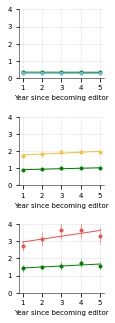

In [23]:
cm = 1/2.54
fig = plt.figure(figsize=(4*cm, 10*cm))

ax = plt.subplot(3, 1, 1)
plotScatter(norm_editor_pub, ax, 'green', 5, 'AutCount')
plotScatter(norm_editor_pub, ax, colors['normal'], 5, 'EdiCount')
styleAx(ax)

ax = plt.subplot(3, 1, 2)
plotScatter(q_editor_pub, ax, 'green', 5, 'AutCount')
plotScatter(q_editor_pub, ax, colors['q'], 5, 'EdiCount')
styleAx(ax)

ax = plt.subplot(3, 1, 3)
plotScatter(bad_editor_pub, ax, 'green', 5, 'AutCount')
plotScatter(bad_editor_pub, ax, colors['bad'], 5, 'EdiCount')
styleAx(ax)

plt.tight_layout()

set_size(3*cm, 10*cm, ax)

plt.savefig(f"../figures/compare_nqs_with_peer.pdf",bbox_inches = 'tight', pad_inches = 0)